## Lesson: Toy Differential Privacy - Simple Database Queries

In this section we're going to play around with Differential Privacy in the context of a database query. The database is going to be a VERY simple database with only one boolean column. Each row corresponds to a person. Each value corresponds to whether or not that person has a certain private attribute (such as whether they have a certain disease, or whether they are above/below a certain age). We are then going to learn how to know whether a database query over such a small database is differentially private or not - and more importantly - what techniques are at our disposal to ensure various levels of privacy


### First We Create a Simple Database

Step one is to create our database - we're going to do this by initializing a random list of 1s and 0s (which are the entries in our database). Note - the number of entries directly corresponds to the number of people in our database.

In [160]:
import torch

# the number of entries in our database
num_entries = 5000

db = torch.rand(num_entries) > 0.5
db

tensor([1, 1, 0,  ..., 0, 0, 0], dtype=torch.uint8)

## Project: Generate Parallel Databases

Key to the definition of differenital privacy is the ability to ask the question "When querying a database, if I removed someone from the database, would the output of the query be any different?". Thus, in order to check this, we must construct what we term "parallel databases" which are simply databases with one entry removed. 

In this first project, I want you to create a list of every parallel database to the one currently contained in the "db" variable. Then, I want you to create a function which both:

- creates the initial database (db)
- creates all parallel databases

In [161]:
db = torch.rand(num_entries) > 0.5
db

tensor([0, 1, 1,  ..., 0, 1, 1], dtype=torch.uint8)

In [162]:
def get_parallel_db(db, remove_index):

    return torch.cat((db[0:remove_index], 
                      db[remove_index+1:]))

In [163]:
get_parallel_db(db, 52352)

tensor([0, 1, 1,  ..., 0, 1, 1], dtype=torch.uint8)

In [164]:
def get_parallel_dbs(db):

    parallel_dbs = list()

    for i in range(len(db)):
        pdb = get_parallel_db(db, i)
        parallel_dbs.append(pdb)
    
    return parallel_dbs

In [165]:
pdbs = get_parallel_dbs(db)

In [166]:
def create_db_and_parallels(num_entries):
    
    db = torch.rand(num_entries) > 0.5
    pdbs = get_parallel_dbs(db)
    
    return db, pdbs

In [167]:
db, pdbs = create_db_and_parallels(20)

# Lesson: Towards Evaluating The Differential Privacy of a Function

Intuitively, we want to be able to query our database and evaluate whether or not the result of the query is leaking "private" information. As mentioned previously, this is about evaluating whether the output of a query changes when we remove someone from the database. Specifically, we want to evaluate the *maximum* amount the query changes when someone is removed (maximum over all possible people who could be removed). So, in order to evaluate how much privacy is leaked, we're going to iterate over each person in the database and measure the difference in the output of the query relative to when we query the entire database. 

Just for the sake of argument, let's make our first "database query" a simple sum. Aka, we're going to count the number of 1s in the database.

In [168]:
db, pdbs = create_db_and_parallels(5000)

In [169]:
def query(db):
    return db.sum()

In [170]:
full_db_result = query(db)

In [171]:
sensitivity = 0
for pdb in pdbs:
    pdb_result = query(pdb)
    
    db_distance = torch.abs(pdb_result - full_db_result)
    
    if(db_distance > sensitivity):
        sensitivity = db_distance

In [172]:
sensitivity

tensor(1)

# Project - Evaluating the Privacy of a Function

In the last section, we measured the difference between each parallel db's query result and the query result for the entire database and then calculated the max value (which was 1). This value is called "sensitivity", and it corresponds to the function we chose for the query. Namely, the "sum" query will always have a sensitivity of exactly 1. However, we can also calculate sensitivity for other functions as well.

Let's try to calculate sensitivity for the "mean" function.

In [173]:
# try this project here!

In [174]:
def query(db):
    return db.type(torch.FloatTensor).mean()

In [175]:
db, pdbs = create_db_and_parallels(5000)
full_db_result = query(db)

sensitivity = 0
for pdb in pdbs:
    pdb_result = query(pdb)
    
    db_distance = torch.abs(pdb_result - full_db_result)
    
    if(db_distance > sensitivity):
        sensitivity = db_distance
sensitivity

tensor(0.0001)

Wow! That sensitivity is WAY lower. Note the intuition here. "Sensitivity" is measuring how sensitive the output of the query is to a person being removed from the database. For a simple sum, this is always 1, but for the mean, removing a person is going to change the result of the query by rougly 1 divided by the size of the database (which is much smaller). Thus, "mean" is a VASTLY less "sensitive" function (query) than SUM.

# Project: Calculate L1 Sensitivity For Threshold

In this first project, I want you to calculate the sensitivty for the "threshold" function. 

- First compute the sum over the database (i.e. sum(db)) and return whether that sum is greater than a certain threshold.
- Then, I want you to create databases of size 10 and threshold of 5 and calculate the sensitivity of the function. 
- Finally, re-initialize the database 10 times and calculate the sensitivity each time.

In [176]:
# try this project here!

In [177]:
def threshold(db, threshold):
    return (db.sum() > threshold).type(torch.IntTensor)

In [178]:
def get_sensitivity(query, n_rows):
    db, pdbs = create_db_and_parallels(n_rows)
    full_db_result = query(db)

    sensitivity = 0
    for pdb in pdbs:
        pdb_result = query(pdb)

        db_distance = torch.abs(pdb_result - full_db_result)

        if(db_distance > sensitivity):
            sensitivity = db_distance
    return sensitivity

In [179]:
get_sensitivity(lambda x: threshold(x, 5), 10)

0

In [180]:
for _ in range(10):
    print(get_sensitivity(lambda x: threshold(x, 5), 10))

0
tensor(1, dtype=torch.int32)
0
0
0
0
0
0
0
0


# Lesson: A Basic Differencing Attack

Sadly none of the functions we've looked at so far are differentially private (despite them having varying levels of sensitivity). The most basic type of attack can be done as follows.

Let's say we wanted to figure out a specific person's value in the database. All we would have to do is query for the sum of the entire database and then the sum of the entire database without that person!

# Project: Perform a Differencing Attack on Row 10

In this project, I want you to construct a database and then demonstrate how you can use two different sum queries to explose the value of the person represented by row 10 in the database (note, you'll need to use a database with at least 10 rows)

In [181]:
# try this project here!

In [182]:
db = torch.rand(5000) > 0.5

Sum

In [183]:
def query(db):
    return db.sum()

In [184]:
query(db) - query(torch.cat([db[:10], db[11:]]))

tensor(1)

Mean

In [185]:
def query(db):
    return db.float().mean()
query(db) - query(torch.cat([db[:10], db[11:]]))

tensor(9.8169e-05)

Threshold

In [186]:
db.sum()

tensor(2546)

In [187]:
def query(db, th):
    return db.sum().float() > th
th = db.sum().item() - 1
query(db, th) - query(torch.cat([db[:10], db[11:]]), th)

tensor(1, dtype=torch.uint8)

# Project: Local Differential Privacy

As you can see, the basic sum query is not differentially private at all! In truth, differential privacy always requires a form of randomness added to the query. Let me show you what I mean.

### Randomized Response (Local Differential Privacy)

Let's say I have a group of people I wish to survey about a very taboo behavior which I think they will lie about (say, I want to know if they have ever committed a certain kind of crime). I'm not a policeman, I'm just trying to collect statistics to understand the higher level trend in society. So, how do we do this? One technique is to add randomness to each person's response by giving each person the following instructions (assuming I'm asking a simple yes/no question):

- Flip a coin 2 times.
- If the first coin flip is heads, answer honestly
- If the first coin flip is tails, answer according to the second coin flip (heads for yes, tails for no)!

Thus, each person is now protected with "plausible deniability". If they answer "Yes" to the question "have you committed X crime?", then it might becasue they actually did, or it might be becasue they are answering according to a random coin flip. Each person has a high degree of protection. Furthermore, we can recover the underlying statistics with some accuracy, as the "true statistics" are simply averaged with a 50% probability. Thus, if we collect a bunch of samples and it turns out that 60% of people answer yes, then we know that the TRUE distribution is actually centered around 70%, because 70% averaged wtih 50% (a coin flip) is 60% which is the result we obtained. 

However, it should be noted that, especially when we only have a few samples, the this comes at the cost of accuracy. This tradeoff exists across all of Differential Privacy. The greater the privacy protection (plausible deniability) the less accurate the results. 

Let's implement this local DP for our database before!

In [188]:
# try this project here!

In [206]:
def generate_db(n_items, th=0.5):
    return (torch.rand(n_items) > th).type(torch.IntTensor)

In [207]:
db = generate_db(10)
db

tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 1], dtype=torch.int32)

In [208]:
import numpy as np

In [209]:
np.random.choice([0, 1], 2)

array([1, 1])

In [210]:
def randomize_db(db):
    result = list()
    for x in db:
        c1, c2 = np.random.choice([0, 1], 2)
        if c1 == 1:
            result.append(x)
        else:
            result.append(c2)
    return torch.Tensor(result)

In [211]:
def randomize_db(db):
    first_coin = (torch.rand(len(db)) > 0.5).float()
    second_coin = (torch.rand(len(db)) > 0.5).float()
    return db.float() * first_coin + (1 - first_coin) * second_coin

In [212]:
randomize_db(db)

tensor([0., 1., 1., 0., 1., 1., 0., 0., 1., 1.])

In [213]:
def query(db):
    return db.float().mean()

In [214]:
query(db)

tensor(0.6000)

In [215]:
for n_items in [10, 100, 1000, 10000]:
    db = generate_db(n_items)
    rdb = randomize_db(db)
    result_true = query(db)
    result_rand = query(rdb)
    print(f'For {n_items} items, the true result is {result_true}, and the randomized one is {result_rand}')

For 10 items, the true result is 0.699999988079071, and the randomized one is 0.20000000298023224
For 100 items, the true result is 0.5099999904632568, and the randomized one is 0.49000000953674316
For 1000 items, the true result is 0.5090000033378601, and the randomized one is 0.503000020980835
For 10000 items, the true result is 0.4970000088214874, and the randomized one is 0.49540001153945923


In [220]:
for n_items in [10, 100, 1000, 10000]:
    db = generate_db(n_items, th=0.3)
    rdb = randomize_db(db)
    result_true = query(db)
    result_rand = query(rdb)
    print(f'For {n_items} items, the true result is {result_true}, and the randomized one is {result_rand}')

For 10 items, the true result is 0.800000011920929, and the randomized one is 0.6000000238418579
For 100 items, the true result is 0.6399999856948853, and the randomized one is 0.5600000023841858
For 1000 items, the true result is 0.7020000219345093, and the randomized one is 0.6129999756813049
For 10000 items, the true result is 0.7085999846458435, and the randomized one is 0.5942000150680542


In [222]:
for n_items in [10, 100, 1000, 10000]:
    db = generate_db(n_items, th=0.3)
    rdb = randomize_db(db)
    result_true = query(db)
    # Uneskewed result
    result_rand = 2 * query(rdb) - 0.5
    print(f'For {n_items} items, the true result is {result_true}, and the randomized one is {result_rand}')

For 10 items, the true result is 0.699999988079071, and the randomized one is -0.09999999403953552
For 100 items, the true result is 0.6200000047683716, and the randomized one is 0.5800000429153442
For 1000 items, the true result is 0.6759999990463257, and the randomized one is 0.6740000247955322
For 10000 items, the true result is 0.6955999732017517, and the randomized one is 0.7017999887466431


# Project: Varying Amounts of Noise

In this project, I want you to augment the randomized response query (the one we just wrote) to allow for varying amounts of randomness to be added. Specifically, I want you to bias the coin flip to be higher or lower and then run the same experiment. 

Note - this one is a bit tricker than you might expect. You need to both adjust the likelihood of the first coin flip AND the de-skewing at the end (where we create the "augmented_result" variable).

In [258]:
# try this project here!

In [259]:
def query(db):
    return db.float().mean()

In [224]:
db = generate_db(100)
db

tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 1], dtype=torch.int32)

In [260]:
def randomize_db(db, noise=0.5):
    first_coin = (torch.rand(len(db)) > (1.0 - noise)).float()
    second_coin = (torch.rand(len(db)) > 0.5).float()
    return db.float() * first_coin + (1 - first_coin) * second_coin

Test the case with n = 100

In [261]:
def rand_query(db, noise=0.5):
    priv_res = query(randomize_db(db, noise))
    return (priv_res - noise * 0.5) / (1 - noise)

In [262]:
import matplotlib.pyplot as plt
%matplotlib inline

In [276]:
def show_errors(n, noise_low, noise_high, num_points):
    db = generate_db(n, 0.5)
    true_results = list()
    priv_results = list()
    noise_values = np.linspace(noise_low, noise_high, num_points)
    for noise in noise_values:
        true_results.append(query(db))
        priv_results.append(rand_query(db, noise))
    true_results = np.array(true_results)
    priv_results = np.array(priv_results)

    plt.scatter(noise_values, np.abs((priv_results - true_results) / true_results), label=str(n))
    plt.xlabel('Noise')
    plt.ylabel('Relative error')
    plt.title(f'n = {n}')

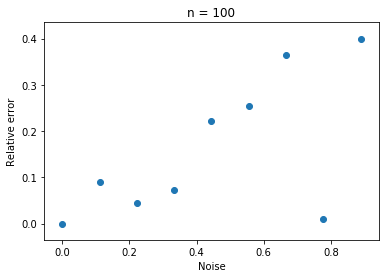

In [277]:
show_errors(100, 0, 1, 10)

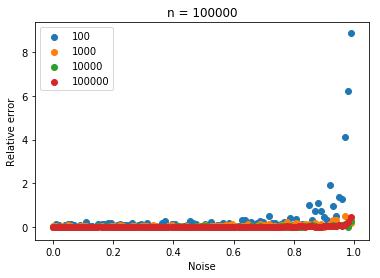

In [281]:
for n in [100, 1000, 10000, 100000]:
    #plt.figure()
    show_errors(n, 0, 1, 100)
plt.legend()

# Lesson: The Formal Definition of Differential Privacy

The previous method of adding noise was called "Local Differentail Privacy" because we added noise to each datapoint individually. This is necessary for some situations wherein the data is SO sensitive that individuals do not trust noise to be added later. However, it comes at a very high cost in terms of accuracy. 

However, alternatively we can add noise AFTER data has been aggregated by a function. This kind of noise can allow for similar levels of protection with a lower affect on accuracy. However, participants must be able to trust that no-one looked at their datapoints _before_ the aggregation took place. In some situations this works out well, in others (such as an individual hand-surveying a group of people), this is less realistic.

Nevertheless, global differential privacy is incredibly important because it allows us to perform differential privacy on smaller groups of individuals with lower amounts of noise. Let's revisit our sum functions.

In [40]:
db, pdbs = create_db_and_parallels(100)

def query(db):
    return torch.sum(db.float())

def M(db):
    query(db) + noise

query(db)

tensor(40.)

So the idea here is that we want to add noise to the output of our function. We actually have two different kinds of noise we can add - Laplacian Noise or Gaussian Noise. However, before we do so at this point we need to dive into the formal definition of Differential Privacy.

![alt text](dp_formula.png "Title")

_Image From: "The Algorithmic Foundations of Differential Privacy" - Cynthia Dwork and Aaron Roth - https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf_

This definition does not _create_ differential privacy, instead it is a measure of how much privacy is afforded by a query M. Specifically, it's a comparison between running the query M on a database (x) and a parallel database (y). As you remember, parallel databases are defined to be the same as a full database (x) with one entry/person removed.

Thus, this definition says that FOR ALL parallel databases, the maximum distance between a query on database (x) and the same query on database (y) will be e^epsilon, but that occasionally this constraint won't hold with probability delta. Thus, this theorem is called "epsilon delta" differential privacy.

# Epsilon

Let's unpack the intuition of this for a moment. 

Epsilon Zero: If a query satisfied this inequality where epsilon was set to 0, then that would mean that the query for all parallel databases outputed the exact same value as the full database. As you may remember, when we calculated the "threshold" function, often the Sensitivity was 0. In that case, the epsilon also happened to be zero.

Epsilon One: If a query satisfied this inequality with epsilon 1, then the maximum distance between all queries would be 1 - or more precisely - the maximum distance between the two random distributions M(x) and M(y) is 1 (because all these queries have some amount of randomness in them, just like we observed in the last section).

# Delta

Delta is basically the probability that epsilon breaks. Namely, sometimes the epsilon is different for some queries than it is for others. For example, you may remember when we were calculating the sensitivity of threshold, most of the time sensitivity was 0 but sometimes it was 1. Thus, we could calculate this as "epsilon zero but non-zero delta" which would say that epsilon is perfect except for some probability of the time when it's arbitrarily higher. Note that this expression doesn't represent the full tradeoff between epsilon and delta.

# Lesson: How To Add Noise for Global Differential Privacy

In this lesson, we're going to learn about how to take a query and add varying amounts of noise so that it satisfies a certain degree of differential privacy. In particular, we're going to leave behind the Local Differential privacy previously discussed and instead opt to focus on Global differential privacy. 

So, to sum up, this lesson is about adding noise to the output of our query so that it satisfies a certain epsilon-delta differential privacy threshold.

There are two kinds of noise we can add - Gaussian Noise or Laplacian Noise. Generally speaking Laplacian is better, but both are still valid. Now to the hard question...

### How much noise should we add?

The amount of noise necessary to add to the output of a query is a function of four things:

- the type of noise (Gaussian/Laplacian)
- the sensitivity of the query/function
- the desired epsilon (ε)
- the desired delta (δ)

Thus, for each type of noise we're adding, we have different way of calculating how much to add as a function of sensitivity, epsilon, and delta. We're going to focus on Laplacian noise. Laplacian noise is increased/decreased according to a "scale" parameter b. We choose "b" based on the following formula.

b = sensitivity(query) / epsilon

In other words, if we set b to be this value, then we know that we will have a privacy leakage of <= epsilon. Furthermore, the nice thing about Laplace is that it guarantees this with delta == 0. There are some tunings where we can have very low epsilon where delta is non-zero, but we'll ignore them for now.

### Querying Repeatedly

- if we query the database multiple times - we can simply add the epsilons (Even if we change the amount of noise and their epsilons are not the same).

# Project: Create a Differentially Private Query

In this project, I want you to take what you learned in the previous lesson and create a query function which sums over the database and adds just the right amount of noise such that it satisfies an epsilon constraint. Write a query for both "sum" and for "mean". Ensure that you use the correct sensitivity measures for both.

In [ ]:
# try this project here!

# Lesson: Differential Privacy for Deep Learning

So in the last lessons you may have been wondering - what does all of this have to do with Deep Learning? Well, these same techniques we were just studying form the core primitives for how Differential Privacy provides guarantees in the context of Deep Learning. 

Previously, we defined perfect privacy as "a query to a database returns the same value even if we remove any person from the database", and used this intuition in the description of epsilon/delta. In the context of deep learning we have a similar standard.

Training a model on a dataset should return the same model even if we remove any person from the dataset.

Thus, we've replaced "querying a database" with "training a model on a dataset". In essence, the training process is a kind of query. However, one should note that this adds two points of complexity which database queries did not have:

    1. do we always know where "people" are referenced in the dataset?
    2. neural models rarely never train to the same output model, even on identical data

The answer to (1) is to treat each training example as a single, separate person. Strictly speaking, this is often overly zealous as some training examples have no relevance to people and others may have multiple/partial (consider an image with multiple people contained within it). Thus, localizing exactly where "people" are referenced, and thus how much your model would change if people were removed, is challenging.

The answer to (2) is also an open problem - but several interesitng proposals have been made. We're going to focus on one of the most popular proposals, PATE.

## An Example Scenario: A Health Neural Network

First we're going to consider a scenario - you work for a hospital and you have a large collection of images about your patients. However, you don't know what's in them. You would like to use these images to develop a neural network which can automatically classify them, however since your images aren't labeled, they aren't sufficient to train a classifier. 

However, being a cunning strategist, you realize that you can reach out to 10 partner hospitals which DO have annotated data. It is your hope to train your new classifier on their datasets so that you can automatically label your own. While these hospitals are interested in helping, they have privacy concerns regarding information about their patients. Thus, you will use the following technique to train a classifier which protects the privacy of patients in the other hospitals.

- 1) You'll ask each of the 10 hospitals to train a model on their own datasets (All of which have the same kinds of labels)
- 2) You'll then use each of the 10 partner models to predict on your local dataset, generating 10 labels for each of your datapoints
- 3) Then, for each local data point (now with 10 labels), you will perform a DP query to generate the final true label. This query is a "max" function, where "max" is the most frequent label across the 10 labels. We will need to add laplacian noise to make this Differentially Private to a certain epsilon/delta constraint.
- 4) Finally, we will retrain a new model on our local dataset which now has labels. This will be our final "DP" model.

So, let's walk through these steps. I will assume you're already familiar with how to train/predict a deep neural network, so we'll skip steps 1 and 2 and work with example data. We'll focus instead on step 3, namely how to perform the DP query for each example using toy data.

So, let's say we have 10,000 training examples, and we've got 10 labels for each example (from our 10 "teacher models" which were trained directly on private data). Each label is chosen from a set of 10 possible labels (categories) for each image.

In [49]:
import numpy as np

In [54]:
num_teachers = 10 # we're working with 10 partner hospitals
num_examples = 10000 # the size of OUR dataset
num_labels = 10 # number of lablels for our classifier

In [55]:
preds = (np.random.rand(num_teachers, num_examples) * num_labels).astype(int).transpose(1,0) # fake predictions

In [56]:
new_labels = list()
for an_image in preds:

    label_counts = np.bincount(an_image, minlength=num_labels)

    epsilon = 0.1
    beta = 1 / epsilon

    for i in range(len(label_counts)):
        label_counts[i] += np.random.laplace(0, beta, 1)

    new_label = np.argmax(label_counts)
    
    new_labels.append(new_label)

In [57]:
# new_labels

# PATE Analysis

In [58]:
labels = np.array([9, 9, 3, 6, 9, 9, 9, 9, 8, 2])
counts = np.bincount(labels, minlength=10)
query_result = np.argmax(counts)
query_result

9

In [59]:
from syft.frameworks.torch.differential_privacy import pate

In [61]:
num_teachers, num_examples, num_labels = (100, 100, 10)
preds = (np.random.rand(num_teachers, num_examples) * num_labels).astype(int) #fake preds
indices = (np.random.rand(num_examples) * num_labels).astype(int) # true answers

preds[:,0:10] *= 0

data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=preds, indices=indices, noise_eps=0.1, delta=1e-5)

assert data_dep_eps < data_ind_eps



In [64]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=preds, indices=indices, noise_eps=0.1, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 11.756462732485115
Data Dependent Epsilon: 1.52655213289881


In [65]:
preds[:,0:50] *= 0

In [66]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=preds, indices=indices, noise_eps=0.1, delta=1e-5, moments=20)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

Data Independent Epsilon: 11.756462732485115
Data Dependent Epsilon: 0.9029013677789843


# Where to Go From Here


Read:
    - Algorithmic Foundations of Differential Privacy: https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf
    - Deep Learning with Differential Privacy: https://arxiv.org/pdf/1607.00133.pdf
    - The Ethical Algorithm: https://www.amazon.com/Ethical-Algorithm-Science-Socially-Design/dp/0190948205
   
Topics:
    - The Exponential Mechanism
    - The Moment's Accountant
    - Differentially Private Stochastic Gradient Descent

Advice:
    - For deployments - stick with public frameworks!
    - Join the Differential Privacy Community
    - Don't get ahead of yourself - DP is still in the early days

# Section Project:

For the final project for this section, you're going to be given a dataset which you need to use to train a DP model using this PATE method. 